***Generating simulated testing data ***

In [1]:
import os
import numpy as np
import logging


from yass.templates.choose import choose_templates
from yass.templates.crop import crop_and_align_templates
from yass.augment.noise import noise_cov
from yass.templates.util import get_templates
from yass.util import load_yaml

# TODO: documentation
# TODO: comment code, it's not clear what it does
def make_testing_data(CONFIG, data_length, ptp_att_std, spike_train, chosen_templates,n_per_cluster,data_folder):
 
    logger = logging.getLogger(__name__)

    path_to_data = os.path.join(data_folder, 'standarized.bin')
    path_to_config = os.path.join(data_folder, 'standarized.yaml')

    # make sure standarized data already exists
    if not os.path.exists(path_to_data):
        raise ValueError('Standarized data does not exist in: {}, this is '
                         'needed to generate training data, run the '
                         'preprocesor first to generate it'
                         .format(path_to_data))

    PARAMS = load_yaml(path_to_config)

    logger.info('Getting templates...')
    n_spikes, _ = spike_train.shape
    
    weighted_spike_train = np.hstack((spike_train,
                                      np.ones((n_spikes, 1), 'int32')))

    # get templates
    templates, _ = get_templates(weighted_spike_train, path_to_data, CONFIG.resources.max_memory, data_length*CONFIG.spike_size)

    templates = np.transpose(templates, (2, 1, 0))

    logger.info('Got templates ndarray of shape: {}'.format(templates.shape))

    # choose good templates (good looking and big enough)
    #templates = choose_templates(templates, chosen_templates)
    templates=templates[chosen_templates]
    if templates.shape[0] == 0:
        raise ValueError("Coulndt find any good templates...")   

    logger.info('Good looking templates of shape: {}'.format(templates.shape))

    # align and crop templates
    templates = crop_and_align_templates(templates, data_length*CONFIG.spike_size,
                               CONFIG.neigh_channels, CONFIG.geom)
    
    # determine noise covariance structure
    spatial_SIG, temporal_SIG = noise_cov(path_to_data,
                                          CONFIG.neigh_channels,
                                          CONFIG.geom,
                                          templates.shape[1])
    
    # make training data set
    K = templates.shape[0]
    #R = CONFIG.spike_size
    #amps = np.max(np.abs(templates), axis=1)

    # make clean augmented spikes
    #nk = int(np.ceil(nspikes/K))
    #if max_amp == 0:
    #    max_amp = np.max(amps)*1.5
     
    #nneigh = templates.shape[2]

    ################
    # clean spikes #
    ################
    x_clean = np.zeros((n_per_cluster*K, templates.shape[1], templates.shape[2]))
    ids=np.zeros(x_clean.shape[0],dtype=int)
    ptp=np.zeros(K)

    for i in range(K):
        ptp[i]=np.ptp(templates[i,:,0])
        
    for k in range(K):
        
        
        tt = templates[k]
        ptp_now=ptp[k]
        ptp_range = (np.random.normal(1,ptp_att_std,n_per_cluster))[:, np.newaxis, np.newaxis]
        
        
        
        x_clean[k*n_per_cluster:(k+1)*n_per_cluster] = tt[np.newaxis, :, :]*ptp_range
        ids[k*n_per_cluster:(k+1)*n_per_cluster]=k

            
    
    #########
    # noise #
    #########
    
    # this is just make_noise with noise_ratio=1

    # get noise
    noise = np.random.normal(size=[x_clean.shape[0], templates.shape[1], templates.shape[2]])
    for c in range(noise.shape[2]):
        noise[:, :, c] = np.matmul(noise[:, :, c], temporal_SIG)

        reshaped_noise = np.reshape(noise, (-1, noise.shape[2]))
    noise = np.reshape(np.matmul(reshaped_noise, spatial_SIG),
                       [noise.shape[0], x_clean.shape[1], x_clean.shape[2]])
       


    x_clean=x_clean+noise
    
   

    return x_clean,noise,ids,ptp

***Loading files (please have your config file ready) ***

In [2]:
import os
import numpy as np
import tensorflow as tf
#import h5py
# import progressbar
%matplotlib inline
import matplotlib.pyplot as plt
#import panda as pd
import pickle
import logging
import scipy.io as sio
import yass
from yass import read_config
from yass.augment import make_training_data
from yass import preprocess
import matplotlib.pyplot as plt


yass.set_config("../../config/49-lab.yaml")
CONFIG = read_config()

***Load Spike Train***

To train the Neural Network, you need to have a recording with sorted result. The result does not need to be perfect.
If you don't have any sorting result yet, you can run yass with threshold detection option. In your configuration file, set spikes.detection = threshold.

spike_train is a matrix of size (number of spikes x 2). Each row represents an individual spike. The first column is the spike time (not in milliseconds or seconds but in actual temporal location in recording). The second column is the spike ID.

In [3]:
import numpy as np
# load ground truth
# make spikeTrain
import scipy.io
from os import path


path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'groundtruth_ej49_data1_set1.mat')

kk = scipy.io.loadmat(path_to_ground_truth)

#L_gt has length total number of spikes; it is the cluster index for each spike
#spt_gt has length total number of spikes; it is the time for each spike
L_gt = kk['L_gt']-1
spt_gt = kk['spt_gt'] +10
spike_train = np.concatenate((spt_gt, L_gt),axis=1)
print (spike_train[0:10])

[[ 17  39]
 [ 23  26]
 [ 61  28]
 [ 80  15]
 [126  10]
 [251  40]
 [278   6]
 [288  42]
 [468  36]
 [545  38]]


***generating testing data!!***


In [24]:
#input parameters for x_test

data_length=12
n_per_cluster=200
ptp_att_std=0.01

data_folder = path.join(path_to_data, 'tmp', 'preprocess')

chosen_templates = [0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48] # should be your own number

x_clean,noise,ids,ptp=make_testing_data(CONFIG, data_length, ptp_att_std, spike_train, chosen_templates,n_per_cluster,data_folder)

100%|██████████| 3/3 [00:23<00:00,  7.79s/it]


In [27]:
np.sort(ptp)

array([ 1.35733071,  2.05126595,  2.36563389,  2.59209073,  4.94614825,
        6.90405164,  6.95197598,  7.25437548,  7.46437095,  7.55336931,
        7.96268903,  8.1104159 ,  8.15070361,  8.64441922,  8.79029302,
        9.01756272,  9.05998291,  9.11176949,  9.33009492,  9.527903  ,
        9.81668135,  9.98706777, 10.33137835, 11.15947234, 11.56221406,
       12.63105888, 12.71945742, 12.81014352, 14.35893156, 14.35981948,
       15.53250044, 17.42910091, 22.47820234, 25.32354125, 25.91392734,
       27.85303281, 28.4482507 , 31.00213346, 36.64074234, 43.06446875,
       43.3528625 , 48.50158798, 61.7089797 , 92.85153825])

In [26]:
print(x_clean.shape, noise.shape, ids.shape, ptp.shape)

(8800, 241, 7) (8800, 241, 7) (8800,) (44,)


In [6]:
from dstools import plot

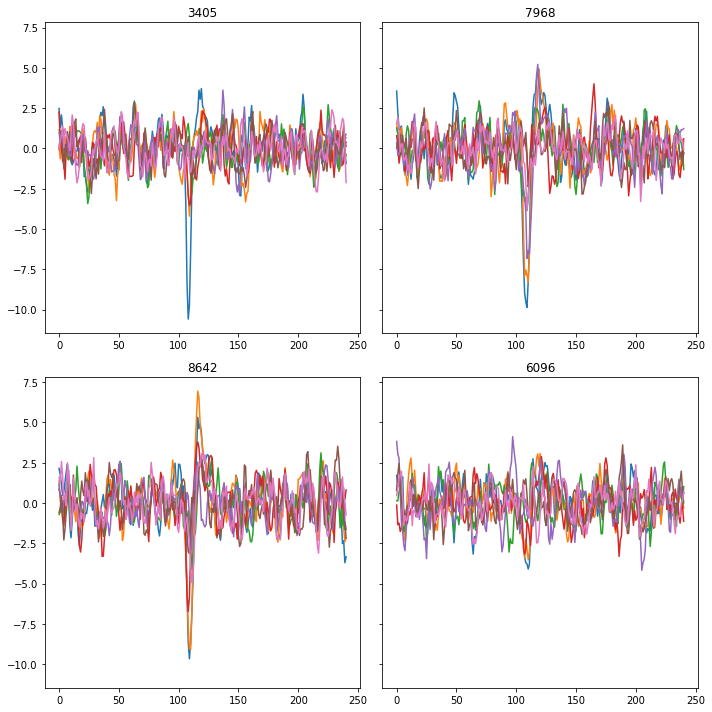

In [18]:
plot.grid_from_array(x_clean, axis=0, elements=4,
                     figsize=(10, 10), sharey=True)

In [ ]:
sio.savemat('retinal_testing.mat',
            mdict={'x_clean':x_clean,
                   'noise':noise,
                   'ids':ids,'ptp':ptp})